# CSML1010 Project Working Copy
# Sentiment Analysis with the Sentiment140 dataset
## Pete Gray - YorkU #217653247

---------------------------------------------------------

## Introduction

In this project we explore and learn about natural language processing and the lifecycle of machine learning projects. Sentiment analysis will be performed using the Sentiment140 dataset[1]. We will explicity execute data cleaning, data exploration, feature engineering, feature selection, modeling, model selection, and [OTHER STUFF?] The code is mostly assembled from bits and pieces of the coding exercises that are part of the course CSML1010, Fall 2019, at York University, Toronto.

[1] http://help.sentiment140.com/for-students

###### TABLE OF CONTENTS

1. Load data and libraries
2. Data Cleaning
3. Data Exploration
4. Feature Engineering
5. Feature Selection

# Import libraries

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=2, linewidth=80)
import warnings
warnings.filterwarnings("ignore")
import model_evaluation_utils as meu


# Adjust pandas display

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = -1

# Import matplotlib and seaborn and adjust defaults

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## Read data from local filesystem and csv source 

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1")

Check data with quick visual inspection

In [5]:
df

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best feeling ever
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me for details
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


## Give dataframe columns

In [6]:
df.columns = ['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [7]:
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

### Now it has columns, this seems better.

### Check for nulls in the Text column

In [8]:
df = df[df["Text"].notnull()]
df.count()

sentiment    1599999
ID           1599999
Time         1599999
none         1599999
username     1599999
Text         1599999
dtype: int64

# Set temporary dataset size, for quicker processing

In [9]:
dev_data_size = 2000

In [10]:
start_row = int(800000-(dev_data_size/2))-1
finish_row = int(800000+(dev_data_size/2))-1
df_sm = df[start_row:finish_row]
df_sm.count()

sentiment    2000
ID           2000
Time         2000
none         2000
username     2000
Text         2000
dtype: int64

In [11]:
columns = [col for col in df.columns if not col.startswith('self')]
columns

['sentiment', 'ID', 'Time', 'none', 'username', 'Text']

In [12]:
raw_text = np.array(df_sm['Text'])
sentiments = np.array(df_sm['sentiment'])
raw_text[5:15]

array(['Very sad news.  Farrah Fawcett passed away.  ',
       "I'm so sad to hear the news about Farrah Fawcett... She was a Corpus Christi native, and will be missed dearly. ",
       'R.I.P. Farrah Fawcett...  A super-hottie to the end.  Now a real angel.',
       'damn my plans 4 2morrow r cancelled now wat am supposed to do ',
       'Rest in peace Farrah Fawcett.  so sad.',
       'Retweeting @secretagentmama: Rest in Peace Farrah Fawcett..  http://is.gd/1dfIb',
       'Yay, Haruhi Endless Eight part 2/3! And I thought two episodes were too many ',
       'We really need to keep doing our parts to help find a cure for cancer. Too many lives have been loss to cancer. RIP Aunt Alice I love you ',
       'Rest in peace Farrah  What a sad day',
       'Ah huge bummer. R.I.P. Sky Saxon. The Seeds owned it in their day   http://bit.ly/mD3pI'],
      dtype=object)

In [13]:
sentiments[4995:5005]

array([], dtype=int64)

-----------------------

# =======================
# Data Cleaning
# =======================

-----------------------

## Cleaning function

In [14]:
import re
def clean(s):
    s = s.replace(r'<lb>', "\n")
    s = s.replace(r'<tab>', "\i")
    
    # As a sanity check - s = s.replace(r'W', "Q")
    
    s = re.sub(r'<br */*>', "\n", s)
    s = s.replace("&lt;", "<").replace("&gt;", ">").replace("&amp;", "&")
    s = s.replace("&amp;", "&")
    # markdown urls
    s = re.sub(r'\(https*://[^\)]*\)', "", s)
    # normal urls
    s = re.sub(r'https*://[^\s]*', "", s)
    s = re.sub(r'_+', ' ', s)
    s = re.sub(r'"+', '"', s)
    
    # NUMBERS IN THE TEXT DATA
    # The numbers in the data came to light during feature engineering. 
    # I will try different things here.
    
    # A processor-efficient approach, as suggested at:
    # https://stackoverflow.com/questions/30315035/strip-numbers-from-string-in-python
    # s = s.translate(None, '0123456789')
    # Well, that totally didn't work.
    
    # From the same link, a more conventional, but less efficient approach:
    
    s = re.sub(r'\d+', '', s)
    
    
    # USERNAMES IN THE DATA
    # Let's see if life gets any cleaner with these removed, or if it just blows stuff up.
    # Using code found at: 
    # https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
    
    s = re.sub('@[^\s]+','',s) 
    
    # Was 4374 for 2000
    # 3593 and 1985
    
    return str(s)

## Observations on the removal of Usernames from data

Running with 2000 rows, Bag of Words came up with 4374 dimensions. This took a dog's age to run through RFE. Applying the removal of usernames (strings beginning with '@') from the text data caused 15 of the 2000 to become null - they were stripped from the dataset. Most significantly, it resulted in a reduction of dimensions at the Bag of Words stage to 3593. While this doesn't appear to enable us to ramp up significantly, it does help.

It is worth noting that there appears to be a bit less gibberish in the selected features after appying this. So, a little quicker, a little cleaner, it's a keeper.

## Create new column in dataframe

In [15]:
df_sm["text_clean"] = ''

# Iterate and clean

In [16]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_clean"] = clean(row.Text)

processed: 799000
processed: 800000


### Check results

In [17]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean
798999,0,2328818606,Thu Jun 25 10:01:34 PDT 2009,NO_QUERY,redstar72,"CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T","CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T"
799000,0,2328818761,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,LIDA360,Charlie lost an angel today Very sad http://twurl.nl/k5bw5m,Charlie lost an angel today Very sad
799001,0,2328818847,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,rnspires21,"at work, and very bored","at work, and very bored"
799002,0,2328819310,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,lasthonestlook,"It's weird how celebrities go in threes. Carradine, McMahon and now Farrah.","It's weird how celebrities go in threes. Carradine, McMahon and now Farrah."
799003,0,2328819347,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,deiann,"@adelate Farrah's dead? Had no idea.. RIP Farrah, indeed.","Farrah's dead? Had no idea.. RIP Farrah, indeed."


## Additional pre-processing: tokenization, removing extra whitespaces, lower casing and more advanced operations like spelling corrections, grammatical error corrections, removing repeated characters.

In [18]:
import nltk
wpt = nltk.WordPunctTokenizer()
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define normalization function

In [19]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [20]:
normalize_corpus = np.vectorize(normalize_document)

In [21]:
df_sm["text_normalized"] = ''

In [22]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
            print('processed:'.format(i), i)
    df_sm.at[i, "text_normalized"] = normalize_corpus(row.text_clean)

processed: 799000
processed: 800000


### check results

In [23]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized
798999,0,2328818606,Thu Jun 25 10:01:34 PDT 2009,NO_QUERY,redstar72,"CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T","CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T",cant beat live music wish could sing '
799000,0,2328818761,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,LIDA360,Charlie lost an angel today Very sad http://twurl.nl/k5bw5m,Charlie lost an angel today Very sad,charlie lost angel today sad
799001,0,2328818847,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,rnspires21,"at work, and very bored","at work, and very bored",work bored
799002,0,2328819310,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,lasthonestlook,"It's weird how celebrities go in threes. Carradine, McMahon and now Farrah.","It's weird how celebrities go in threes. Carradine, McMahon and now Farrah.","weird celebrities go threes carradine , mcmahon farrah ."
799003,0,2328819347,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,deiann,"@adelate Farrah's dead? Had no idea.. RIP Farrah, indeed.","Farrah's dead? Had no idea.. RIP Farrah, indeed.","farrahs dead idea .. rip farrah , indeed ."
...,...,...,...,...,...,...,...,...
800994,4,1468005450,Mon Apr 06 23:13:13 PDT 2009,NO_QUERY,KiwiBeck,I have this strange desire to go to confession!!!!!,I have this strange desire to go to confession!!!!!,strange desire go confession !!!
800995,4,1468005505,Mon Apr 06 23:13:14 PDT 2009,NO_QUERY,astrologee,@i_reporter answer sent in dm. try it,reporter answer sent in dm. try it,reporter answer sent dm try
800996,4,1468005511,Mon Apr 06 23:13:16 PDT 2009,NO_QUERY,Melamachinko,"@brooklynunion cuz ur 3pm is my 9am and Id be either asleep or airport- bound... Ima sneak sum'n special in 4u, tho ;-)","cuz ur pm is my am and Id be either asleep or airport- bound... Ima sneak sum'n special in u, tho ;-)","cuz ur pm id either asleep airport bound .. ima sneak sum ' n special u , tho ;-)"
800997,4,1468005581,Mon Apr 06 23:13:16 PDT 2009,NO_QUERY,Yahtzee27,@littrellfans Its all good. Just figured you would like to know.,Its all good. Just figured you would like to know.,good figured would like know


In [24]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [25]:
for i, row in df_sm.iterrows():
    if i % 1000 == 0:
        print(i)
    if(row["text_normalized"] and len(str(row["text_normalized"])) < 1000000):
        doc = nlp(str(row["text_normalized"]))
        adjectives = []
        nouns = []
        verbs = []
        lemmas = []

        for token in doc:
            lemmas.append(token.lemma_)
            if token.pos_ == "ADJ":
                adjectives.append(token.lemma_)
            if token.pos_ == "NOUN" or token.pos_ == "PROPN":
                nouns.append(token.lemma_)
            if token.pos_ == "VERB":
                verbs.append(token.lemma_)
                
        df_sm.at[i, "text_lemma"] = " ".join(lemmas)                
        df_sm.at[i, "text_nouns"] = " ".join(nouns)
        df_sm.at[i, "text_adjectives"] = " ".join(adjectives)
        df_sm.at[i, "text_verbs"] = " ".join(verbs)
        df_sm.at[i, "text_nav"] = " ".join(nouns+adjectives+verbs)
        df_sm.at[i, "no_tokens"] = len(lemmas)

799000
800000


In [26]:
df_sm

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
798999,0,2328818606,Thu Jun 25 10:01:34 PDT 2009,NO_QUERY,redstar72,"CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T","CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T",cant beat live music wish could sing ',can not beat live music wish could sing ',music wish,live,can beat could sing,music wish live can beat could sing,9.00
799000,0,2328818761,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,LIDA360,Charlie lost an angel today Very sad http://twurl.nl/k5bw5m,Charlie lost an angel today Very sad,charlie lost angel today sad,charlie lost angel today sad,charlie lost angel today,sad,,charlie lost angel today sad,5.00
799001,0,2328818847,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,rnspires21,"at work, and very bored","at work, and very bored",work bored,work bored,work bored,,,work bored,2.00
799002,0,2328819310,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,lasthonestlook,"It's weird how celebrities go in threes. Carradine, McMahon and now Farrah.","It's weird how celebrities go in threes. Carradine, McMahon and now Farrah.","weird celebrities go threes carradine , mcmahon farrah .","weird celebrity go threes carradine , mcmahon farrah .",celebrity threes carradine mcmahon farrah,weird,go,celebrity threes carradine mcmahon farrah weird go,9.00
799003,0,2328819347,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,deiann,"@adelate Farrah's dead? Had no idea.. RIP Farrah, indeed.","Farrah's dead? Had no idea.. RIP Farrah, indeed.","farrahs dead idea .. rip farrah , indeed .","farrah dead idea .. rip farrah , indeed .",farrah idea,dead,rip,farrah idea dead rip,9.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800994,4,1468005450,Mon Apr 06 23:13:13 PDT 2009,NO_QUERY,KiwiBeck,I have this strange desire to go to confession!!!!!,I have this strange desire to go to confession!!!!!,strange desire go confession !!!,strange desire go confession ! ! !,desire confession,strange,go,desire confession strange go,7.00
800995,4,1468005505,Mon Apr 06 23:13:14 PDT 2009,NO_QUERY,astrologee,@i_reporter answer sent in dm. try it,reporter answer sent in dm. try it,reporter answer sent dm try,reporter answer send dm try,reporter answer dm,,send try,reporter answer dm send try,5.00
800996,4,1468005511,Mon Apr 06 23:13:16 PDT 2009,NO_QUERY,Melamachinko,"@brooklynunion cuz ur 3pm is my 9am and Id be either asleep or airport- bound... Ima sneak sum'n special in 4u, tho ;-)","cuz ur pm is my am and Id be either asleep or airport- bound... Ima sneak sum'n special in u, tho ;-)","cuz ur pm id either asleep airport bound .. ima sneak sum ' n special u , tho ;-)","cuz ur pm -PRON- would either asleep airport bind .. -PRON- be going to sneak sum ' n special u , tho ;-)",ur pm airport sneak sum u tho,asleep special,would bind be,ur pm airport sneak sum u tho asleep special would bind be,22.00
800997,4,1468005581,Mon Apr 06 23:13:16 PDT 2009,NO_QUERY,Yahtzee27,@littrellfans Its all good. Just figured you would like to know.,Its all good. Just figured you would like to know.,good figured would like know,good figured would like know,figured,good,would know,figured good would know,5.00


In [27]:
# Save in case we need it later:


df_sm = df_sm[df_sm["text_nav"].notnull()]
df_sm.count()

# shuffle the dataset for later.
# Note this isn't necessary (the dataset is shuffled again before used), 
# but is good practice.
# df = df.sample(frac=1)

sentiment          1985
ID                 1985
Time               1985
none               1985
username           1985
Text               1985
text_clean         1985
text_normalized    1985
text_lemma         1985
text_nouns         1985
text_adjectives    1985
text_verbs         1985
text_nav           1985
no_tokens          1985
dtype: int64

----------------------------------------

# Saving Cleaned Data to the Filesystem

### So I can run without re-cleaning, or move a chunk to the Cloud for experiments.

In [28]:
# save cleaned data

# df_sm.to_csv('cleaned01.csv', encoding='utf-8', index=False)

# Loading Cleaned Data from the Filesystem

### Saved in various sizes, load as appropriate

In [29]:
# df_sm = pd.read_csv("s140_cln_100k.csv", encoding="utf-8")

## s140_cln_100k.csv

----------------------------

# =========================
# Data Exploration
# =========================

----------------------------

### Is dataset balanced?

We know that the original dataset is split right down the middle, with 800,000 positive documents and 799,999 negative. Let's check that:

In [30]:
df['sentiment'].value_counts()

4    800000
0    799999
Name: sentiment, dtype: int64

Excellent. Now, let's check that our hackishly sampled little subset is also balanced:

In [31]:
df_sm['sentiment'].value_counts()

4    993
0    992
Name: sentiment, dtype: int64

Excellent! Perfectly balanced.

### Show data types in each column

In [32]:
df_sm.dtypes

sentiment          int64  
ID                 int64  
Time               object 
none               object 
username           object 
Text               object 
text_clean         object 
text_normalized    object 
text_lemma         object 
text_nouns         object 
text_adjectives    object 
text_verbs         object 
text_nav           object 
no_tokens          float64
dtype: object

### Summary of numerical features

Not the most useful thing, but helpful as a quick sanity check.

In [33]:
df_sm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sentiment,1985.00,2.00,2.00,0.00,0.00,4.00,4.00,4.00
ID,1985.00,1898243817.53,430657959.41,1467822272.00,1467917337.00,1468005607.00,2329004031.00,2329205794.00
no_tokens,1985.00,8.70,5.26,1.00,5.00,8.00,12.00,32.00


### Exploring text at different levels of cleaning

In [34]:
df_sm[['text_clean','text_normalized','text_lemma','text_nav']].sample(10)

,text_clean,text_normalized,text_lemma,text_nav
799438,"Farrah Fawcett, you'll always be an angel to me",farrah fawcett youll always angel,farrah fawcett -PRON- will always angel,farrah fawcett will angel
799826,"yikes. Luckily, I'm obsessed with those simply asia noodle bowls so I'll just stick to those.",yikes luckily ' obsessed simply asia noodle bowls ' stick .,yike luckily ' obsess simply asia noodle bowls ' stick .,yike asia noodle bowls stick obsess
800281,heyyyyyy want to hook it up!! lol,heyyyyyy want hook lol,heyyyyyy want hook lol,heyyyyyy hook lol want
799967,Miami is awesome so sad my trip is almost over,miami awesome sad trip almost,miami awesome sad trip almost,miami awesome trip sad
799213,Doing homework at the beach,homework beach,homework beach,homework beach
800351,Our picnic will be fabulous!,picnic fabulous,picnic fabulous,fabulous picnic
800683,I havent but since you turned me on to it..I will all of them!,havent since turned iti !,have not since turn iti !,iti turn
799819,god i wish i had your drive/determination. i've been telling myself for months i'd start working out but i havent,god wish drivedetermination ' telling months ' start working havent,god wish drivedetermination ' tell month ' start work have not,god wish drivedetermination month start tell work
800027,reaching amritsar in an hour and (if i find a bus) should be at wagah border by pm -,reaching amritsar hour find bus wagah border pm -,reach amritsar hour find bus wagah border pm -,amritsar hour bus border pm wagah reach find
800911,GOOD MORNING MY LADYS and Jon lol!,good morning ladys jon lol,good morning ladys jon lol,morning jon good ladys lol


In [35]:
# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

### Creating a List of Tokens from a List of Documents

In [36]:
def my_tokenizer(text):
    return text.split() if text != None else []

In [37]:
tokens = df_sm.text_nav.map(my_tokenizer).sum()

In [38]:
print(tokens[:200])

['music', 'wish', 'live', 'can', 'beat', 'could', 'sing', 'charlie', 'lost', 'angel', 'today', 'sad', 'work', 'bored', 'celebrity', 'threes', 'carradine', 'mcmahon', 'farrah', 'weird', 'go', 'farrah', 'idea', 'dead', 'rip', 'news', 'farrah', 'fawcett', 'sad', 'pass', 'sad', 'news', 'farrah', 'fawcett', 'corpus', 'christi', 'native', 'be', 'hear', 'miss', 'farrah', 'fawcett', 'end', 'angel', 'super', '-', 'hottie', 'real', 'rip', 'damn', 'morrow', 'r', 'wat', 'plan', 'cancel', 'suppose', 'peace', 'farrah', 'fawcett', 'sad', 'rest', 'rest', 'peace', 'farrah', 'fawcett', 'retweete', 'yay', 'haruhi', 'part', 'episode', 'endless', 'many', 'think', 'part', 'cancer', 'life', 'loss', 'cancer', 'aunt', 'love', 'cure', 'many', 'alice', 'need', 'keep', 'help', 'find', 'rip', 'peace', 'farrah', 'day', 'sad', 'rest', 'bummer', 'ri', 'sky', 'saxon', 'seed', 'day', 'huge', 'own', 'jinxed', 'mood', 'happy', 'cause', 'nicks', 'father', 'sharon', 'baby', 'farrah', 'good', 'say', 'be', 'die', 'know', 'ah

### Counting Frequencies with a Counter

In [39]:
from collections import Counter

counter = Counter(tokens)
counter.most_common(20)

[('farrah', 290),
 ('fawcett', 205),
 ('go', 197),
 ('sad', 159),
 ('be', 155),
 ('good', 140),
 ('get', 119),
 ('day', 111),
 ('love', 101),
 ('rip', 100),
 ('work', 88),
 ('know', 85),
 ('miss', 84),
 ('die', 80),
 ('want', 78),
 ('see', 77),
 ('quot', 76),
 ('today', 74),
 ('make', 72),
 ('time', 71)]

In [40]:
print([t[0] for t in counter.most_common(200)]) 

['farrah', 'fawcett', 'go', 'sad', 'be', 'good', 'get', 'day', 'love', 'rip', 'work', 'know', 'miss', 'die', 'want', 'see', 'quot', 'today', 'make', 'time', 'think', 'thank', 'night', 's', 'feel', 'pass', 'rest', 'peace', 'new', 'angel', 'morning', 'say', 'u', 'would', 'cancer', 'need', 'watch', 'can', 'hope', 'take', 'hear', 'come', 'lol', 'tomorrow', 'could', 'last', 'great', 'tonight', 'friend', 'guy', 'bed', 'twitter', 'sleep', 'find', 'happy', 'bad', 'wish', 'thing', 'family', 'try', 'look', 'leave', 'tell', 'charlie', 'news', 'may', 'hour', 'week', 'lose', 'show', 'life', 'way', 'tweet', 'wait', 'sorry', 'nice', 'use', 'people', 'start', 'hair', 'year', 'eat', 'let', 'hate', 'long', 'man', 'school', 'much', 'fun', 'give', 'guess', 'home', 'read', 'break', 'next', 'have', 'suck', 'haha', 'glad', 'r', 'yay', 'beautiful', '#', 'head', 'mean', 'many', 'help', 'will', 'meet', 'omg', 'prayer', 'play', 'call', 'late', 'sweet', 'little', 'girl', 'post', 'hot', 'well', 'person', 'first', 

### Remove stopwords from list of tokens

In [41]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]

# rebuild counter
counter = Counter(remove_stopwords(tokens))

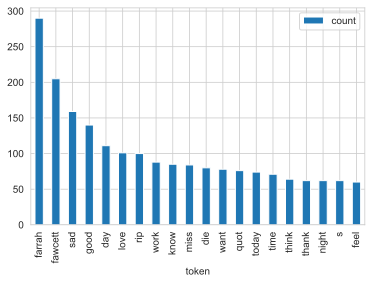

In [42]:
# convert list of tuples into data frame
freq_df = pd.DataFrame.from_records(counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
freq_df.plot(kind='bar', x='token');

## Word clouds

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

In [44]:
from wordcloud import WordCloud

def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, 
                   background_color="white", 
                   max_words=200) 
    wc.generate_from_frequencies(counter)

    # Plot
    fig=plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

#### The Word Cloud!!

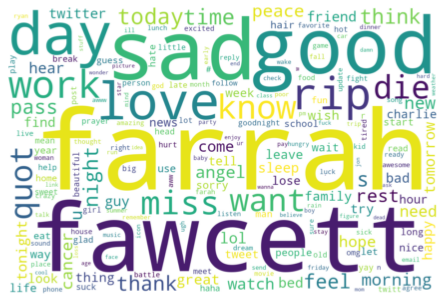

In [45]:
wordcloud(counter)

### Positive words, negative words

Let's do some charts and clouds for exclusively positive or negative samples.

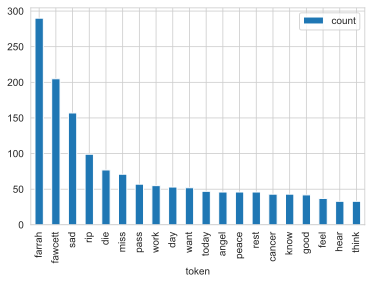

In [46]:
neg_df = df_sm[df_sm['sentiment']==0]
neg_tokens = neg_df.text_nav.map(my_tokenizer).sum()
neg_counter = Counter(neg_tokens)
#neg_counter.most_common(20)
neg_counter = Counter(remove_stopwords(neg_tokens))
neg_freq_df = pd.DataFrame.from_records(neg_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
neg_freq_df.plot(kind='bar', x='token');

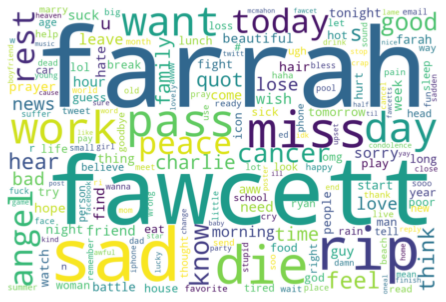

In [47]:
wordcloud(neg_counter)

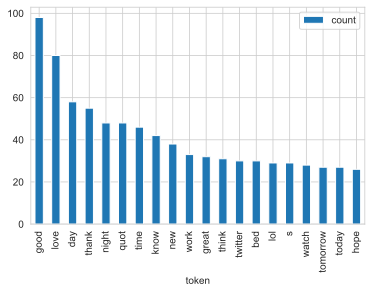

In [48]:
pos_df = df_sm[df_sm['sentiment']==4]
pos_tokens = pos_df.text_nav.map(my_tokenizer).sum()
pos_counter = Counter(pos_tokens)
#pos_counter.most_common(20)
pos_counter = Counter(remove_stopwords(pos_tokens))
pos_freq_df = pd.DataFrame.from_records(pos_counter.most_common(20),
                                    columns=['token', 'count'])

# create bar plot
pos_freq_df.plot(kind='bar', x='token');

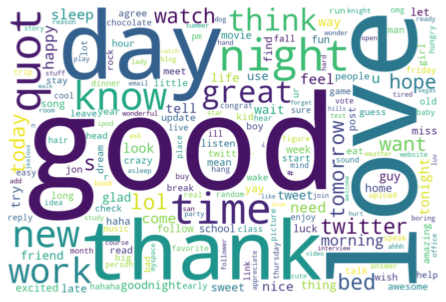

In [49]:
wordcloud(pos_counter)

Well, WOW, those are some mighty positive words, in the positive documents word cloud! 

The most frequently occurring words are clearly different in the text labeled as positive and the text labeled as negative.

In the early phases of development, we were using a dataset, centered around the change at 800,000 rows, with 4000 samples. In this sample, the words "Farrah" and "Fawcett" were the most common words. This suggested perhaps that we need to be more careful about subsampling our data (perhaps a random selection approach would yeild less weird results?) it made for a surprise when we looked at positive and negative sentiment. Who would have thought that "Farrah" and "Fawcett" would be exclusively from statements with negative sentiment? Surprised me, for sure, but there it is. Data Exploration!

## Exploring text complexity

In [50]:
df_sm['no_tokens'] = df_sm.text_lemma\
  .map(lambda l: 0 if l==None else len(l.split()))

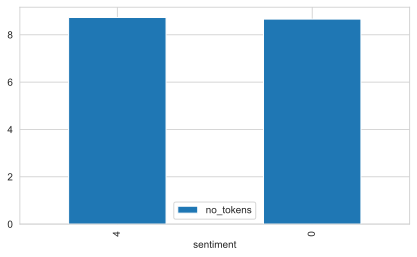

In [51]:
# mean number of tokens by sentiment
df_sm.groupby(['sentiment']) \
  .agg({'no_tokens':'mean'}) \
  .sort_values(by='no_tokens', ascending=False) \
  .plot(kind='bar', figsize=(7,4));

In [52]:
# render plots as retina or png, because svg is very slow
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

def multi_boxplot(data, x, y, ylim = None):
    '''Wrapper for sns boxplot with cut-off functionality'''
    # plt.figure(figsize=(30, 5))
    fig, ax = plt.subplots()
    plt.xticks(rotation=90) 

    # order boxplots by median
    ordered_values = data.groupby(x)[[y]] \
                         .median() \
                         .sort_values(y, ascending=False) \
                         .index
        
    sns.boxplot(x=x, y=y, data=data, palette='Set2', 
                order=ordered_values)

    fig.set_size_inches(11, 6)
    
    # cut-off y-axis at value ylim
    ax.set_ylim(0, ylim)

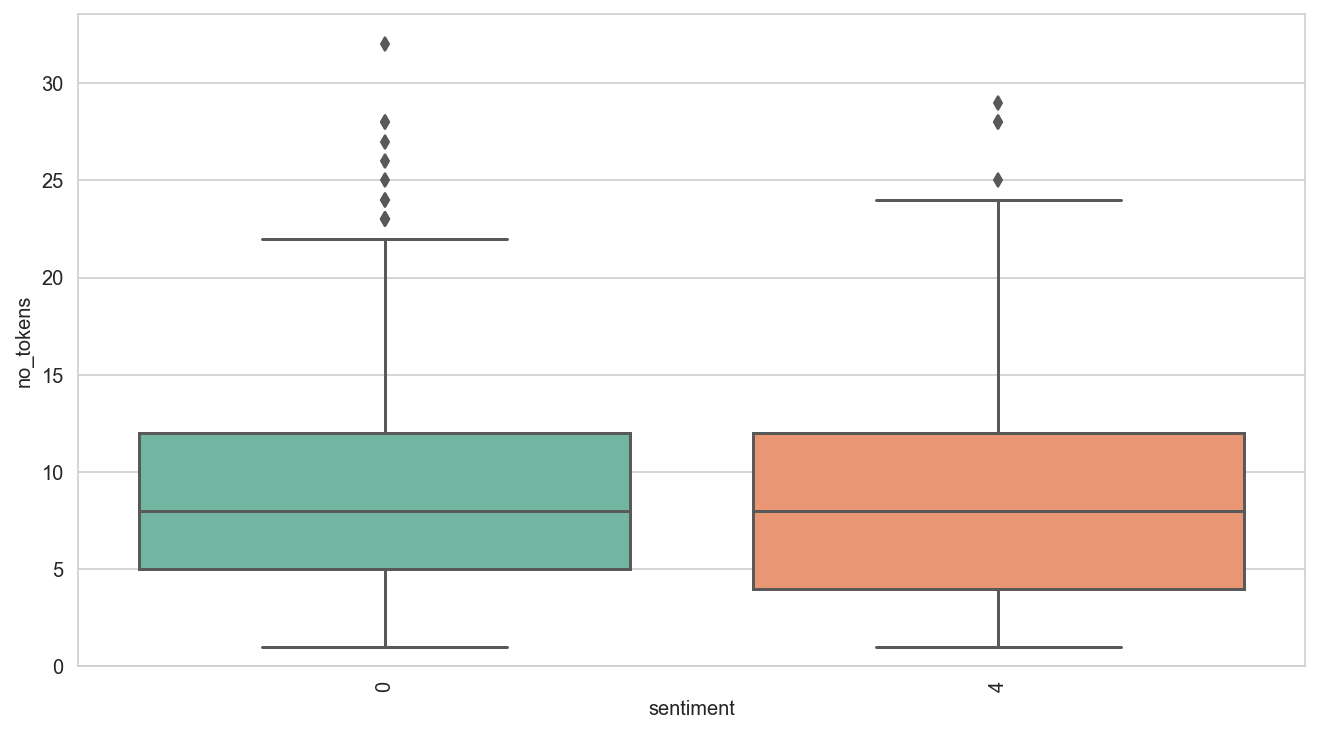

In [53]:
multi_boxplot(df_sm, 'sentiment', 'no_tokens');

In [54]:
# print text of outliers
df_sm['text_lemma'][df_sm.no_tokens > 1500]

Series([], Name: text_lemma, dtype: object)

In [55]:
# cut-off diagram at y=40

# CAREFUL!!! this isn't that meaningful, and it takes for freaking ever to plot, even with only 4000 rows!!!

# multi_boxplot(df_sm, 'username', 'no_tokens', ylim=40)

------------------------------------------

# ===============================
# Feature Engineering
# ===============================

--------------------------------------------

Feature Engineering and Feature Selection are part of the Data Preparation stage of the CRISP-DM methodology. After data has been cleaned and explored, it must be transformed from raw, unstructured text into a structured numeric format that can be used as inputs for our models. Simpler Data Engineering techniques focus on vectorizing individual words, with little emphasis on the contexts of the words. We use Bag of Words and Bag of N-Grams to explore these simpler approaches. While easy to use, and not terribly demanding in terms of computer power required, these techniques are fundamentally less powerful than more modern, processor intensive techniques that concern themselves more with the context of the words. We use pre-trained word embeddings for our advanced feature engineering efforts, in order to avoid computational bottlenecks. If time allows, we may attempt to train our own embedding at some point.

### A vector space model is simply a mathematical model to represent unstructured text (or any other data) as numeric vectors, such that each dimension of the vector is a specific feature\attribute.

## Bag of Words Model

The bag of words model represents each text document as a numeric vector where each dimension is a specific word from the corpus and the value could be its frequency in the document, occurrence (denoted by 1 or 0) or even weighted values. The model’s name is such because each document is represented literally as a ‘bag’ of its own words, disregarding word orders, sequences and grammar.

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(df_sm['text_nav'])
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [57]:
# get all unique words in the corpus
vocab_bagowords = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab_bagowords)

,aaaaahhhh,aaaand,aaargh,aaawwww,aaru,abay,abby,abc,ability,abit,able,absolute,absorb,academy,access,...,yud,yum,yup,yuri,yvonne,zara,zealand,zebra,zhen,zippy,zone,zta,½c,½s,½se
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1982,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Micro dataframe visualization experiment

To satisfy my curiosity, I'm going to make up a teeny weeny little dataframe, to see if I can see some values in one of these arrays as it gets previewed here in the pandas dataframe thing. We just see the corners. All zeroes. Let's see if it looks more satisfying with just a handful of rows...

In [58]:
df_micro = df_sm[1:10]
cv_micro = CountVectorizer(min_df=0., max_df=1.)
cv_micro_matrix = cv_micro.fit_transform(df_micro['text_nav'])
cv_micro_matrix = cv_micro_matrix.toarray()
cv_micro_matrix

array([[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
      

In [59]:
# get all unique words in the corpus
vocab_micro = cv_micro.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_micro_matrix, columns=vocab_micro)

,angel,be,bored,cancel,carradine,celebrity,charlie,christi,corpus,damn,dead,end,farrah,fawcett,go,...,news,pass,peace,plan,real,rest,rip,sad,super,suppose,threes,today,wat,weird,work
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0


### Oh, that's much more gratifying!

While it's clearly useless from a practical perspective, it's nice to be able to see some numbers that aren't zeroes and let me know that the code is doing the thing I expect the code to be doing. I've got to try this on the next ones, too!

## Bag of N-Grams model

A word is just a single token, often known as a unigram or 1-gram. We already know that the Bag of Words model doesn’t consider order of words. But what if we also wanted to take into account phrases or collection of words which occur in a sequence? N-grams help us achieve that. An N-gram is basically a collection of word tokens from a text document such that these tokens are contiguous and occur in a sequence. Bi-grams indicate n-grams of order 2 (two words), Tri-grams indicate n-grams of order 3 (three words), and so on. The Bag of N-Grams model is hence just an extension of the Bag of Words model so we can also leverage N-gram based features. The following example depicts bi-gram based features in each document feature vector.

In [96]:
# you can set the n-gram range to 1,2 to get unigrams as well as bigrams
bv = CountVectorizer(ngram_range=(2,5))
bv_matrix = bv.fit_transform(df_sm['text_nav'])

bv_matrix = bv_matrix.toarray()
vocab_ngrams = bv.get_feature_names()
pd.DataFrame(bv_matrix, columns=vocab_ngrams)

,aaaaahhhh zippy,aaaaahhhh zippy next,aaaaahhhh zippy next do,aaaaahhhh zippy next do stop,aaaand portfolio,aaaand portfolio time,aaaand portfolio time enough,aaaand portfolio time enough make,aaargh cold,aaargh cold fine,aaargh cold fine add,aaargh cold fine add be,aaawwww farrah,aaawwww farrah ri,aaawwww farrah ri die,...,zta due wks,zta due wks work,zta due wks work day,½s poker,½s poker face,½s poker face itï,½s poker face itï ½s,½s xd,½s xd day,½s xd day school,½s xd day school today,½se auf,½se auf toast,½se auf toast germandoo,½se auf toast germandoo joy
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1981,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1982,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


This gives us feature vectors for our documents, where each feature consists of a bi-gram representing a sequence of two words and values represent how many times the bi-gram was present for our documents.

### And now with the Micro Dataframe:

In [61]:
bv_micro = CountVectorizer(ngram_range=(2,2))
bv_micro_matrix = bv_micro.fit_transform(df_micro['text_nav'])

bv_micro_matrix = bv_micro_matrix.toarray()
vocab_micro = bv_micro.get_feature_names()
pd.DataFrame(bv_micro_matrix, columns=vocab_micro)

,angel super,angel today,be hear,cancel suppose,carradine mcmahon,celebrity threes,charlie lost,christi native,corpus christi,damn morrow,dead rip,end angel,farrah fawcett,farrah idea,farrah weird,...,morrow wat,native be,news farrah,peace farrah,plan cancel,real rip,sad news,sad pass,sad rest,super hottie,threes carradine,today sad,wat plan,weird go,work bored
0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
5,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,...,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


# TF-IDF Model

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency. There are multiple variants of this model but they all end up giving quite similar results.

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(df_sm['text_nav'])
tv_matrix = tv_matrix.toarray()

vocab_tfidf = tv.get_feature_names()
pd.DataFrame(np.round(tv_matrix, 2), columns=vocab_tfidf)

,aaaaahhhh,aaaand,aaargh,aaawwww,aaru,abay,abby,abc,ability,abit,able,absolute,absorb,academy,access,...,yud,yum,yup,yuri,yvonne,zara,zealand,zebra,zhen,zippy,zone,zta,½c,½s,½se
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1981,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1982,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1983,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Gotta try that with the Micro Dataframe...

In [63]:
tv_micro = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_micro_matrix = tv_micro.fit_transform(df_micro['text_nav'])
tv_micro_matrix = tv_micro_matrix.toarray()

vocab_micro = tv_micro.get_feature_names()
pd.DataFrame(np.round(tv_micro_matrix, 2), columns=vocab_micro)

,angel,be,bored,cancel,carradine,celebrity,charlie,christi,corpus,damn,dead,end,farrah,fawcett,go,...,news,pass,peace,plan,real,rest,rip,sad,super,suppose,threes,today,wat,weird,work
0,0.42,0.00,0.00,0.00,0.00,0.00,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.32,0.00,0.00,0.00,0.49,0.00,0.00,0.00
1,0.00,0.00,0.71,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.71
2,0.00,0.00,0.00,0.00,0.40,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.21,0.00,0.40,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.40,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.58,0.00,0.30,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.39,0.00,...,0.50,0.59,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.36,0.00,0.00,0.00,0.00,0.00,0.36,0.36,0.00,0.00,0.00,0.19,0.23,0.00,...,0.30,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.21,0.26,0.00,...,0.00,0.00,0.00,0.00,0.40,0.00,0.34,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.41,0.00,0.00,0.00,0.00,0.00,0.41,0.00,0.00,0.41,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.29,0.37,0.00,...,0.00,0.00,0.57,0.00,0.00,0.57,0.00,0.37,0.00,0.00,0.00,0.00,0.00,0.00,0.00


--------------------------------------

# ===========================
# Feature Selection
# ===========================

--------------------------------------

Feature Selection is an essential step, which allows us to identify which features are most important to the predictive abilities of our models. Filter methods of Feature Selection involve looking at individual features in isolation, giving them a score by which they can be ranked in terms of their usefulness. We use Univariate Chi-squared statistical tests. Wrapper methods of Feature Selection consider sets of features in combination, which can give deeper insights into which features to select given their interactions and correlations with one another. We use Recursive Feature Elimination and Bagged Decision Trees for this type of feature selection. There are also Embedded Feature Selection techniques, however, these are done in concert with the modeling phase of the project, and if they will be attempted, they will be attempted during the modeling phase of the project.

## Filter Method

### The scikit-learn library provides the SelectKBest class that uses the chi squared (chi^2) statistical test to select the best features

Our Bag of Words vectorization has provided us with over a thousand features. SelectKBest can identify which of these features are most strongly correlated with our sentiment label. We produce a new Bag of Words containing only the features SelectKBest determines are most important.

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# select the 500 features that have the strongest correlation to a class from the
# original thousands of features
selector = SelectKBest(chi2, k=500)
selected_features = \
bow_selected = selector.fit(cv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features

array([  16,   24,   28,   44,   47,   50,   61,   69,   90,   92,   98,  103,
        112,  120,  133,  140,  155,  164,  185,  186,  188,  208,  237,  250,
        252,  256,  263,  265,  267,  273,  275,  292,  313,  319,  322,  338,
        351,  355,  359,  365,  366,  371,  373,  374,  383,  403,  415,  426,
        427,  432,  452,  454,  472,  473,  482,  491,  494,  525,  532,  538,
        563,  568,  578,  584,  596,  614,  617,  622,  641,  643,  648,  667,
        670,  677,  686,  691,  693,  695,  704,  705,  709,  719,  726,  734,
        740,  744,  750,  771,  786,  804,  809,  811,  832,  833,  835,  850,
        866,  877,  891,  894,  895,  904,  912,  924,  941,  942,  947,  982,
       1009, 1011, 1025, 1026, 1060, 1068, 1070, 1077, 1078, 1086, 1087, 1088,
       1095, 1097, 1103, 1109, 1123, 1151, 1168, 1174, 1229, 1233, 1234, 1271,
       1291, 1293, 1301, 1305, 1315, 1316, 1319, 1335, 1350, 1356, 1388, 1391,
       1401, 1411, 1422, 1424, 1439, 1448, 1451, 145

## Interpreting the Selected Features

That array of numbers tells us which indecies of the Bag of Words vectorization were deemed most important by SelectKBest. Kind of boring on its own. It would be much more gratifying to see the actual words it has decided are most important.

## View list of words selected by SelectKBest

In [65]:
for x in selected_features:
    print(vocab_bagowords[x], end=' ')

account actress add age agree ahhh airport album amazing american anal angel anne answer appreciate arm asleep attack awesome awful aww bad battle beach bear beautiful bed bedtime beer believe beloved bill bless blog blue boo boring bottle bowl boy boyfriend brand brave brazil bright brush bug bummer bump bunny buy bye cancel cancer car carradine carter chance charlie check chocolate christi cinema class close college com comin concert condolence congrat cookie cool corpus count couple courageous course crap crappy crazy cross cry cure cute cvs dad daughter dead dentist depressed design die diego different disease documentary donnie drag dread dream drinking drunk dun easter easy ed enjoy event everyday excite excited family farah farrah faucet faucett fawcet fawcett fawcetts feather feature feel felt fight flag follow food fudge fund funeral gettin give glad gmail god good goodbye goodnight grade great gross hahaha hair hand happy hate hates headache hear heartbroken heaven high hill 

## Wrapper Method

### Recursive Feature Elimination

The Recursive Feature Elimination (or RFE) method works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

In [66]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [67]:
model = LogisticRegression(solver='lbfgs', max_iter=10)
rfe = RFE(model, 500)
fit = rfe.fit(cv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False  True False]
Feature Ranking: [1290 1107 2233 ... 1354    1 2129]


In [68]:
i=0
for x in fit.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

able add addict afraid agree ahhh ahhhh airport album amazing angel answer appreciate argh argue arm artistic attack awesome awful aww baby back bad bb be beach bear bed bekuz believe bike blaaaaarg blib blog blue bog bold bonjour boo boogie bout boy boyfriend brand bridge brush brussels bunny burning butt buy bye cable campus can cancel cancer car carry carter centrelink chance change channel charlie chat cheap cheers cheese chocolate cinema city clean cliff close code college com computer condolence congrat contact conversation cookery cookie count couple course crap creek cry cute dad damn dayit ddi death decision determined die different direct discourse disney dog donnie draag drink drinking drive drug dump dun dvd easter easy embarressed empty enough entire error everyday excite excited facebook fact faction farah farrah fawcett fawke feature feel fierce fight finish finished first fish fisl flag follow food freakin free friday frustrating fuck fucking fund funeral gal ghost gig 

## More Wrapper Methods

## Bagged Decision Trees - ExtraTreesClassifier classifier class

In [69]:
from sklearn.ensemble import ExtraTreesClassifier

In [70]:
# feature extraction
model_bagged = ExtraTreesClassifier(n_estimators=10)
model_bagged.fit(cv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged.feature_importances_)
# np.set_printoptions(threshold=200)

[1.36e-04 2.14e-04 0.00e+00 ... 9.61e-05 1.10e-04 1.73e-06]


In [71]:
i=0
n=0
min_imp = 0.00041
for x in model_bagged.feature_importances_:
    if x>min_imp:
        print(vocab_bagowords[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

able ad afraid age agree ahh ahhh ahhhh airport album alex amazing andrewcilley angel angry answer argh arm art asap awesome awful aww awww back bad battle be beach bear beautiful bed begin believe big bit blackberrys bog bonjour boo bored boy boyfriend break buddy bug bump buy bye california call can cancel cancer car care caring carry cast chance change charlie chat checkin cheer chilly chocolate city claim class close come compete computer condition condolence congrat contact contest cooking cool could count couple course crap crappy crazy credit crutch cry cut cute cw dad dam damn day daylol decision depressed die direct do dread drink drinking drop dude dumps dundrum dunno easy eat ed email end endless english enjoy excite excited facebook family farah farewell farrah favorite fawcett fed feel fell fellow fence fierce fight find fish fisl flavor flop follow follower food forget friend fritz fuck fucking fun fund funeral funny game gang get gig girl give glad gmail go god godplease

## Feature Selection on TF-IDF encoded features

### Filter Method - SelectKBest

In [72]:
selector_tfidf = SelectKBest(chi2, k=500)
selected_features_tfidf = \
selector_tfidf.fit(tv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_tfidf

array([  16,   24,   28,   40,   44,   47,   50,   61,   69,   90,   92,   98,
        103,  112,  120,  133,  140,  148,  155,  172,  185,  186,  188,  192,
        202,  208,  237,  241,  250,  256,  263,  265,  267,  273,  275,  281,
        300,  313,  317,  319,  322,  324,  333,  338,  339,  340,  343,  365,
        366,  371,  373,  374,  377,  391,  393,  399,  409,  410,  415,  425,
        426,  452,  454,  472,  473,  482,  491,  494,  512,  522,  525,  532,
        538,  539,  563,  568,  578,  591,  596,  597,  617,  629,  643,  648,
        663,  665,  667,  670,  677,  686,  691,  693,  695,  704,  705,  709,
        710,  719,  722,  726,  733,  734,  740,  750,  753,  765,  786,  791,
        803,  804,  809,  811,  818,  832,  833,  835,  840,  852,  862,  866,
        877,  891,  895,  904,  910,  912,  923,  932,  941,  942,  947,  953,
        974,  982,  985,  997, 1009, 1011, 1025, 1026, 1028, 1030, 1037, 1060,
       1068, 1070, 1074, 1075, 1077, 1078, 1086, 108

In [73]:
for x in selected_features_tfidf:
    print(vocab_tfidf[x], end=' ')

account actress add afraid age agree ahhh airport album amazing american anal angel anne answer appreciate arm artistic asleep aussie awesome awful aww awwww back bad battle bb beach beautiful bed bedtime beer believe beloved beta bit bless blib blog blue blush bold boo boogie book boom boy boyfriend brand brave brazil breakfast bro broadband brother bud buddy bug bummed bummer buy bye cancel cancer car carradine carter cel challenge chance charlie check checkin chocolate christi cinema cleveland close clothe com company condolence congrat conversation cook cookie cool corpus count couple courageous course crap crappy crazy cream cross cruise cry cupcakes cure cute dad dam dark dead debby denise dentist depressed design determined die diego different direct disney dnt documentary donnie drag dream drinking drug drunk dumps dvd easter easy ed effect encouragement enjoy entertain error event everyday excite excited exciting exhausted extend family farah farrah fast fat faucet faucett faw

## RFE on TF-IDF vectors 

In [74]:
model_tfidf = LogisticRegression(solver='lbfgs', max_iter=10)
rfe = RFE(model_tfidf, 500)
fit_tfidf = rfe.fit(tv_matrix, df_sm['sentiment'])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 500
Selected Features: [False False False ... False  True False]
Feature Ranking: [1290 1107 2233 ... 1354    1 2129]


In [75]:
i=0
for x in fit_tfidf.support_:
    if x:
        print(vocab_bagowords[i], end=' ')
    i=i+1

able account add afraid age agree ahhh ahhhh airport album amazing angel anne answer appreciate arm art asleep attack awesome awful aww back bad battle bb be beach bear beautiful bed beer believe bit blaaaaarg blackberrys blib blog blue boo book boring boy boyfriend brand brother brush brussels bug bunny buy bye can cancel cancer car care carradine carter cause cel centrelink chance change charlie check chocolate cinema close clothe com computer condition condolence confuse congrat conversation cook cookie cool could count couple course crap crappy crazy crutch cry cupcakes cute dad dam damn day decision depressed die different direct disney dog dollar donnie drag draw dread dream drink drinking drunk dumps dvd early easy ed enjoy error event everyday excite excited exciting face fail family farah farrah favorite fawcett feature feel fell fierce fight finish flag follow food free friday fritz fuck full fund funeral get gig girl girllllll give glad gmail go god godplease good goodbye go

# Selecting TF-IDF Features with Bagged Decision Trees

### This represents our most sophisticated feature selection method, being used with our most sophisticated feature engineering method.

Earlier, in the Feature Engineering section, we vectorized our text data using the Term Frequency - Inverse Document Frequency method. This resulted in our documents being represented as vectors with thousands of dimensions. Here we will select the most statistically relevant dimensions using a Wrapper Method known as an Extra Trees Classifier, which is an example of Bagged Decision Trees. 

In [76]:
model_bagged_tfidf = ExtraTreesClassifier(n_estimators=20)
model_bagged_tfidf.fit(tv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_tfidf.feature_importances_)
# np.set_printoptions(threshold=200)

[0.00e+00 4.40e-04 7.64e-05 ... 5.58e-05 6.74e-05 4.09e-07]


In [77]:
i=0
n=0
min_imp = 0.00040
for x in model_bagged_tfidf.feature_importances_:
    if x>min_imp:
        print(vocab_tfidf[i], end=' ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

aaaand able afraid age agree ahhh ahhhh album alex amazing andrewcilley angel angry answer arm art asap attack awesome awful aww bad barrie battle be beach beautiful bed believe big bit blaaaaarg blackberrys blew boo book bored bowls boy boyfriend break bridge brush brussels bug bummed bunny buy bye california call can cancel cancer car care carter cat chance change chargin charlie cheer chill chilly chocolate cinema city close college come comin complete computer condition condolence confuse congrat cool could counting couple course crap crappy crazy credit crutch cry cut cute dad dam damn damnnn day dayit daylol deck die dnt do dollar drink dumps dun dundrum easy eat eb ed email embarressed endless english enjoy enough esurance excite excited eye face facebook fall family farah farrah favorite fawcett fed feel fell fellow felt fence fierce fight figure find finished first flag flavor follow fomo food forgot free friday friend fritz fuck fun fund funeral game gen get gig giggle girl g

# A record and summary of 6 types of Feature Selection

### Running with 2000 samples gave us vectors with around 5000 dimensions. After much running time, we were able to visually inspect the 500 most important features, as selected by each method. It is perhaps not informative to look at, and compare, these lists of features - but it is fun. And it may give some "subconscious" intuition into that age-old question, "What are these things thinking?" So, before I disable some of these, so I can run bigger datasets through all this code, here's a record of this activity, in the comments/markdown.

I will, quite simple, strip the top two and bottom two rows of each output, and paste them here with clear labels. Pretty sure I won't be running RFE going forward - spins forever, with a pretty low number of samples.

#### SelectKBest with Bag of Words
account actress add age agree ahhh airport album amazing angel anne answer appreciate arm asleep aussie awesome awful aww bad battle be beach beautiful bed bedtime beer believe bless blog boo boring boy boyfriend brand brave bummed buy can cancel cancer ... upsetting ur use va vacation vacuum vegas version voice vote wait wake wallpaper want wat watch watchin way website weekend welcome wife window wish woke woman wonderful woo work world worth wrist wrong wtf www xavier xd yay yayyy years young yvonne 
#### RFE with Bag of Words
add addict afraid agree ahhh airport album alex allan allow amazing angel architek argh arm artistic attack attitudee awesome awful aww baby back bad be beach bear bed believe berianreed bike bingo blib blink bog bold bonjour boo boogie bout boy ... vacation vegas version vital vote wait wallpaper wanna want warning wat watch way weekend welcome whoops whyyyy wid wife will win wish woke wonder wonderful word work wrath wreak write wrong wtf xavier xd yay yeahh yesterday young youtube yud 
#### Extra Trees Forest with Bag of Words
able add addict afraid age agentbooth agree ahhhh airport album alex allow amazing amby andrewcilleytmail angel angiebert angry arm art attitudee austin authentic awesome awful aww bad banana bar battle be beach beautiful bed believe berianreed bit ... video vmprfreak vote wait wake wanna want warm warning watch way weak weather wee week weekend well whole wife wish wishing wonder wonderful work working workout worry would wrong wullufdude xavier xbeckaxockx xfftlmyheartx yay year young yud yuri
#### SelectKBest with TF-IDF
account actress add afraid age agree ahhh airport album amazing amby american anal ang angel angelsmind anne annoy answer appreciate arm ash asleep augustineiv aussie awesome awful aww awwww bad battle bb beach beautiful bed bedtime beer ... upsetting urbanthai use va vacation vegas version vmprfreak voice vote wait wake wallpaper want watch way website weekend welcome wife will window wish wishing woke wolfsoul woman wonderful woo work wrong wtf xd yay yayyy yoavsegal young yvonne
#### RFE with TF-IDF
account add afraid age agentbooth agree ahhh ahhhh airport album alex amazing angel angelsmind anne annoy answer appreciate arm art asleep aussie awesome awful aww back bad battle be beach bear beautiful bed believe berianreed bit blaaaaarg blackberrys ... upsetting va vacation vegas version vmprfreak vote wait wake wallpaper wanna want wat watch way wee weekend welcome whole wife will win window wish wishing woke wonder wonderful woo word work wrong wtf xbeckaxockx xd xfftlmyheartx yay young yud
#### Extra Trees Forest with TF-IDF
able add addict afraid age agentbooth agree ahhh ahhhh airport album alex andrewcilleytmail angel answer architek arm art asianpersuazion ask attack attitudee awesome awful aww baby bad battle be beach beautiful bed believe berianreed bit ... vote wait wake walmart wanna want warm warneronstine warning watch way weather week weekend welcome well whole wife will win window wish wishing woke woman wonder word work working would wrong wullufdude xfftlmyheartx xoxo yay yeanot year young yud  





## Last but (maybe) not least - Selecting with our Bag-of-N-Grams

#### Comparing features for Bag-o-words and TF-IDF was very much like comparing apples with apples.

This is going to look a little different, I'll bet, so I'll keep it out from between those two.

In [97]:
# select the 50 features that have the strongest correlation to a class from the
# original thousands of features
selector_ngrams = SelectKBest(chi2, k=500)
selected_features_ngrams = \
ngrams_selected = selector_ngrams.fit(bv_matrix, df_sm['sentiment']).get_support(indices=True)
selected_features_ngrams

array([  150,   151,   152,   153,   177,   443,   472,   473,   474,   483,
         490,   496,   511,   512,   513,   517,   521,   944,   992,   996,
        1013,  1145,  1289,  1310,  1396,  1406,  1435,  1445,  1496,  1517,
        1533,  1580,  1584,  1665,  1779,  1782,  2352,  2488,  2558,  2559,
        2816,  2820,  2823,  2825,  2845,  2850,  2877,  2908,  2947,  2973,
        2974,  3295,  3324,  3325,  3326,  3329,  3339,  3932,  4084,  4131,
        4180,  4197,  4668,  4781,  4831,  4833,  4885,  4915,  4921,  5175,
        5176,  5184,  5203,  5805,  5824,  5838,  6468,  6475,  6506,  6591,
        6644,  6667,  6673,  6686,  6695,  6704,  6708,  6712,  6720,  6721,
        6725,  6741,  6744,  6764,  6765,  6768,  6773,  6784,  6785,  6799,
        6800,  6812,  6825,  6830,  6831,  6832,  6847,  6881,  6886,  6889,
        6896,  6907,  6911,  6916,  6923,  6931,  6935,  6941,  6943,  6948,
        6951,  6957,  6958,  6959,  6962,  6975,  6978,  6979,  6987,  6988,

In [98]:
for x in selected_features_ngrams:
    print(vocab_ngrams[x], end=' - || - ')

afternoon thank - || - afternoon thank leaving - || - afternoon thank leaving sad - || - afternoon thank leaving sad theresa - || - age sad - || - angel angel - || - angel farrah - || - angel farrah fawcett - || - angel farrah fawcett original - || - angel good - || - angel heaven - || - angel peace - || - angel quot - || - angel quot cancer - || - angel quot cancer die - || - angel rip - || - angel sad - || - aww farrah - || - awww farrah - || - awww farrah fawcett - || - awwww farrah - || - bad feel - || - battle cancer - || - battle cancer sad - || - be can - || - be die - || - be hear - || - be leave - || - be take - || - be watch - || - beach day - || - beautiful rip - || - beautiful sad - || - bed night - || - believe die - || - believe pass - || - break die - || - brush guy - || - bummed farrah - || - bummed farrah fawcett - || - can believe - || - can believe die - || - can believe pass - || - can go - || - can wait - || - can wait see - || - cancer age - || - cancer die - || -

 - || - prayer farrah - || - print freebie - || - print freebie neat - || - print freebie neat publish - || - print freebie neat publish use - || - publish use - || - quot cancer - || - quot cancer die - || - quot charlie - || - quot charlie angel - || - quot charlie angel quot - || - quot charlie angel quot cancer - || - quot life - || - quot mean - || - response ihad - || - response ihad answer - || - response ihad answer find - || - rest peace - || - rest peace farrah - || - rest peace farrah fawcett - || - right good - || - rip farah - || - rip farah fawcett - || - rip farrah - || - rip jill - || - rip know - || - rip lose - || - rip miss - || - rip sad - || - rip see - || - rip take - || - rip will - || - rip will miss - || - role model - || - ryan neal - || - ryan oneal - || - sad be - || - sad can - || - sad can believe - || - sad die - || - sad farrah - || - sad farrah fawcett - || - sad farrah fawcett hear - || - sad farrah fawcett hear pass - || - sad fight - || - sad find - 

Well, that was weird...

What were you doing when you heard Elvis was dead?

Pulling into a McDonald's parking lot with my Dad.

John Lennon?

Calling a friend about a BASIC programming quesiton.

Farrah Fawcett?

Reading a list of N-Grams from a huge Twitter dataset that had been chosen by SelectKBest. 

Guess I missed that, 10 years ago. 

# RFE with Bag of N-Grams?

## Sorry, no.

## RFE takes a fabulously long time, even with a few thousand dimensions.

My bag-o-n-grams has 2-grams, 3-grams, and 4-grams. It's kinda fun. With 2000 samples, it has TENS of THOUSANDS of dimensions. I think RFE, in general, won't play a big role in my plans. I suppose I could run this on a few hundred samples to see if it works. But so what if it does? Can't move ahead with any constructive with dinky little dataframes like that. 

# Let's do the forest with the ngrams and call it a day.

In [99]:
model_bagged_ngrams = ExtraTreesClassifier(n_estimators=20)
model_bagged_ngrams.fit(bv_matrix, df_sm['sentiment'])
# np.set_printoptions(threshold=np.inf)
print(model_bagged_ngrams.feature_importances_)
# np.set_printoptions(threshold=200)

[2.65e-06 5.83e-06 1.23e-06 ... 1.02e-06 1.45e-06 2.40e-06]


In [102]:
i=0
n=0
min_imp = 0.0004
for x in model_bagged_ngrams.feature_importances_:
    if x>min_imp:
        print(vocab_ngrams[i], end=' - || - ')
        n=n+1
    i=i+1
print(' ')
print(' ')
print('Number of Features with minimum importance ', min_imp, ': ', n)

ahhhh fall - || - angel heaven - || - angel sad - || - angels trio - || - angry be - || - angry be piss - || - appetite be - || - ashh miss - || - ashh miss funny - || - awesome trip - || - awful little - || - aww close - || - aww sad - || - awww dd - || - awww dd wrong - || - awww farrah - || - bad feel - || - bah pass - || - balcony hawaii miss - || - battle cancer - || - be can - || - be leave - || - be loner - || - be take - || - be watch - || - beach day - || - beautiful rip - || - bed night - || - bit long - || - blaaaaarg hour - || - blaaaaarg hour go - || - blackberrys fritz - || - blew tire - || - boyfriend miss - || - brush guy - || - bubba butterfly mad - || - butterfly mad - || - can believe - || - can go - || - can wait - || - can wait see - || - cancer kind - || - cancer kind sure - || - cancer life - || - car break - || - car overheated - || - cat miss - || - cat sad - || - charlie angel - || - charlie angels - || - charlie angels trio - || - cobra tv dang - || - compute

# Milestone 1 - Conclusion

### Data has been loaded, cleaned, and explored.

### Feature Engineering has been carried out using Bag of Words, Bag of N-Grams, and TF-IDF (Term Frequency - Inverse Document Frequency)

### Three Feature Selection methods, Select K Best, Recursive Feature Elimination, and Bagged Decision Trees, have been carried out on the engineered features.

### A sample of cleaned data has been saved to a file, for use in an "Advanced" part of this project using Tensorflow and ELMo in The Cloud.

Dec 14 2019

---------------------

-----------------------

-----------------------

----------------------

----------------------

---------------------
#
#
#
### End of working working file.
#
#
#

## Sentiment Analysis with Afinn

As a quick and dirty sanity check, I've set up Afinn in the early stages of data cleaning, and intend to keep a little record of Afinn's performance, as I increase the rigour of the data cleaning.

In [79]:
from afinn import Afinn

afn = Afinn(emoticons=True)

In [80]:
texts = np.array(df_sm['text_nav'])
sentiments = np.array(df_sm['sentiment'])

# extract data for model evaluation
#train_texts = texts[:10000]
#train_sentiments = sentiments[:10000]

#test_texts = texts[40000:60000]
#test_sentiments = sentiments[40000:60000]
sample_ids = [626, 533, 310, 123, 654, 400]

In [81]:
#for text_clean, sentiment in zip(texts[sample_ids], sentiments[sample_ids]):
#    print('TEXT:', texts)
#    print('Actual Sentiment:', sentiment)
#    print('Predicted Sentiment polarity:', afn.score(texts))
#    print('-'*60)

TEXT: ['music wish live can beat could sing' 'charlie lost angel today sad'
 'work bored' ... 'ur pm airport sneak sum u tho asleep special would bind be'
 'figured good would know' 'remember']
Actual Sentiment: 0


TypeError: cannot use a string pattern on a bytes-like object

In [ ]:
# Predict sentiment with Afinn

sentiment_polarity = [afn.score(Text) for Text in normalized_texts]
#predicted_sentiments = ['positive' if score >= 1.0 else 'negative' for score in sentiment_polarity]
predicted_sentiments = [4 if score >= 1.0 else 0 for score in sentiment_polarity]

In [ ]:
#meu.display_model_performance_metrics(true_labels=test_texts, predicted_labels=predicted_sentiments, 
#                                  classes=['positive', 'negative'])
#meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predicted_sentiments, 
                                  classes=[4, 0])

## Checking cleaning with Afinn

I'm curious about how deeper cleaning affects predicitive models. So I set up Afinn after the very first round of data cleaning, and am going to track results here in the markdown. For simplicity, I will monitor the effects of different levels of cleaning on "weighted avg f1-score"

Round 1, most basic cleaning, 20000 rows:  0.63

Round 2, include normalization, 20000 rows: 0.63

In [103]:
df_sm.head()

,sentiment,ID,Time,none,username,Text,text_clean,text_normalized,text_lemma,text_nouns,text_adjectives,text_verbs,text_nav,no_tokens
798999,0,2328818606,Thu Jun 25 10:01:34 PDT 2009,NO_QUERY,redstar72,"CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T","CAN'T BEAT LIVE MUSIC, WISH I COULD SING BUT I CAN'T",cant beat live music wish could sing ',can not beat live music wish could sing ',music wish,live,can beat could sing,music wish live can beat could sing,9
799000,0,2328818761,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,LIDA360,Charlie lost an angel today Very sad http://twurl.nl/k5bw5m,Charlie lost an angel today Very sad,charlie lost angel today sad,charlie lost angel today sad,charlie lost angel today,sad,,charlie lost angel today sad,5
799001,0,2328818847,Thu Jun 25 10:01:35 PDT 2009,NO_QUERY,rnspires21,"at work, and very bored","at work, and very bored",work bored,work bored,work bored,,,work bored,2
799002,0,2328819310,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,lasthonestlook,"It's weird how celebrities go in threes. Carradine, McMahon and now Farrah.","It's weird how celebrities go in threes. Carradine, McMahon and now Farrah.","weird celebrities go threes carradine , mcmahon farrah .","weird celebrity go threes carradine , mcmahon farrah .",celebrity threes carradine mcmahon farrah,weird,go,celebrity threes carradine mcmahon farrah weird go,9
799003,0,2328819347,Thu Jun 25 10:01:37 PDT 2009,NO_QUERY,deiann,"@adelate Farrah's dead? Had no idea.. RIP Farrah, indeed.","Farrah's dead? Had no idea.. RIP Farrah, indeed.","farrahs dead idea .. rip farrah , indeed .","farrah dead idea .. rip farrah , indeed .",farrah idea,dead,rip,farrah idea dead rip,9


## Save to database

In [ ]:
df.to_sql('df_sm', con)